
## Schedulers for miniai


In [1]:
import torch
import fastcore.all as fc
import numpy as np
from torch import tensor
import math

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt

from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
     

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]


## Simple Scheduler

Exponential scheduler for learning rate

An exponential scheduler implementation that works with PyTorch's optimizers and miniai callbacks.

Thanks to [Francisco Mussari](https://gist.github.com/fmussari/d485075eec7d76cdc043d830d20db5a7)


In [ ]:
sched_exp

In [91]:
# function from fastai schedule
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [129]:
import pdb
# function from fastai schedule
def sched_exp(start, end, pos): return start * (end/start) ** pos

class ExpSchedLR():
    def __init__(self, optimizer, T_max, start=None, end=0):
        self.optimizer = optimizer
        self.final_i = T_max - 1
        self.end = end
        if not start: self.starts = [group['lr'] for group in self.optimizer.param_groups] 
        else: self.starts = [start for group in self.optimizer.param_groups]
        self._step_count = 0
        self.step()
        # import pdb; pdb.set_trace()
        

    def step(self):
        """
        Updates optmizers learning rate
        """
        values = self.get_lr()
        for data in zip(self.optimizer.param_groups, values):
            pg, lr = data
            # print("before pg['lr']->", pg['lr'])
            pg['lr'] = lr
            # print("after pg['lr']->", pg['lr'])    
        self._step_count += 1

    def get_lr(self):
        pos = self._step_count
        return [sched_exp(start, self.end, pos/self.final_i) for start in self.starts]

In [130]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

def _lr(cb): return cb.pg['lr']
rec = RecorderCB(lr=_lr)
rec.order = -1 

In [131]:
epochs = 1
tmax = epochs * len(dls.train)
sched = partial(ExpSchedLR, T_max=tmax, end=0.005)

In [132]:
bsch = BaseSchedCB(sched)

In [133]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra = [BatchSchedCB(sched), rec]
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

accuracy,loss,epoch,train
0.804,0.528,0,train
0.850,0.401,0,eval


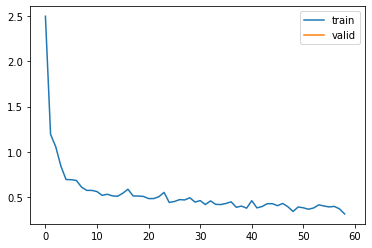

In [134]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

### How is the learning rate update in pytorch??

note the scheduler updates the learning rate in optmizer

In [140]:
# Define a simple model
model = nn.Linear(10, 1)

# Create an optimizer with initial learning rate
initial_lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=initial_lr)

# Create a scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop
for epoch in range(10):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}, Learning Rate: {current_lr:.6f}")


Epoch 0, Learning Rate: 0.090000
Epoch 1, Learning Rate: 0.081000
Epoch 2, Learning Rate: 0.072900
Epoch 3, Learning Rate: 0.065610
Epoch 4, Learning Rate: 0.059049
Epoch 5, Learning Rate: 0.053144
Epoch 6, Learning Rate: 0.047830
Epoch 7, Learning Rate: 0.043047
Epoch 8, Learning Rate: 0.038742
Epoch 9, Learning Rate: 0.034868


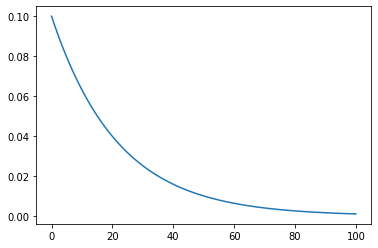

In [142]:
start, end, T_max = 0.1, 0.001, 100
lr_values = [sched_exp(start, end, i/T_max) for i in range(0, T_max+1)]
plt.plot(range(T_max+1), lr_values);


In [58]:
sched_exp??

Signature: sched_exp(start, end, pos)
Docstring: <no docstring>
Source:    def sched_exp(start, end, pos): return start * (end/start) ** pos
File:      /tmp/ipykernel_1557/3094456810.py
Type:      function


In [62]:
lr_values[-3:]

[0.0010964781961431851, 0.0010471285480508996, 0.001]

In [69]:
start * (end/start) ** (0/T_max) , start * (end/start) ** (50/T_max), start * (end/start) ** (100/T_max)  

(0.1, 0.010000000000000002, 0.001)